# Introduction

This is an exercise to learn more about time series prediction using LSTM RNNs. The [dataset](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#) runs from 1949 to 1960 and has a monthly total number of international passengers for each month in that time period. The problem to solve is, given a month and year, to predict the number of passengers that will fly internationally in that time period. (Passenger numbers are given in thousands)

This work is adapted from http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

First, let's load up the raw data and plot it:

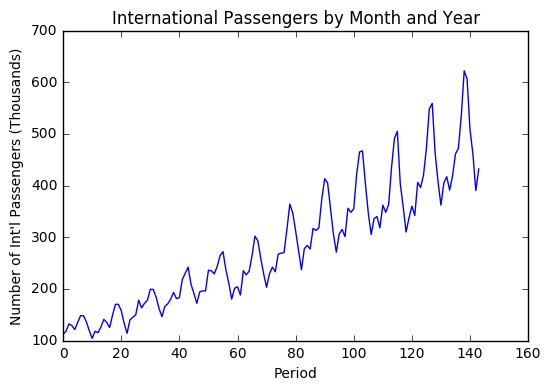

In [11]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(43)

# load the data
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# plot the raw data
plt.title("International Passengers by Month and Year")
plt.xlabel("Period")
plt.ylabel("Number of Int'l Passengers (Thousands)")

plt.plot(dataset)
plt.show()

We can see a couple of things from the plot:
1. There is a peak in international travel around the same period every year
2. There is a general upward trend indicating that the demand for travel is continually increasing over this time period

# A Note on Activation Functions

When designing a neural network with sigmoid or tanh activation functions in any layer, it's important to keep in mind how these activations affect both the forward and backward passes through the layers. 

Looking at the plot of the sigmoid function below, we see that any value less than about -5.0 will evaluate to approximately zero and any value greater than about 5.0 will evaluate to 1. So if we have initial values from our examples that are large or initial weights that are large, we'll essentially force the output of the layer's activations to produce a nearly binary (0 or 1) vector of output values. Clearly, it's important to keep the initial values from our training examples within a certain range centered around zero, and we can accomplish that through normalizing the dataset.

When the forward pass is done and it's time to run backprop to change the parameters in the network, we evaluate the gradient of the sigmoid activation (z * (1-z)). Again, if we've produced a binary output vector from the forward pass, the gradient will be zero or close to zero and the remainder of the backward pass will produce parameter update values near zero, resulting in no change to the network parameters and effectively stopping the network from learning.

It's a similar story for the tanh activation function, so consider yourself warned! For further reading, consider Yann LeCun et al's [classic "Efficient BackProp" paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

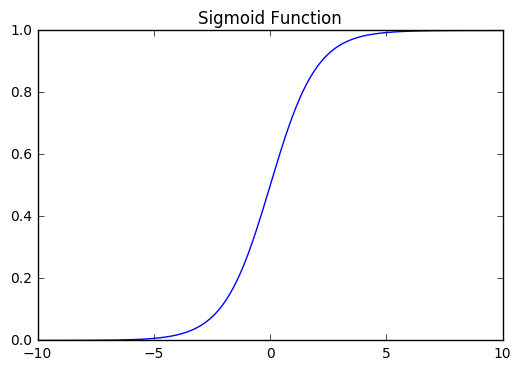

In [8]:
def sigmoid(t):
    return (1 / (1 + numpy.exp(-t)))

t = numpy.arange(-10, 10, 0.01)

plt.title("Sigmoid Function")
plt.plot(t,sigmoid(t))
plt.show()

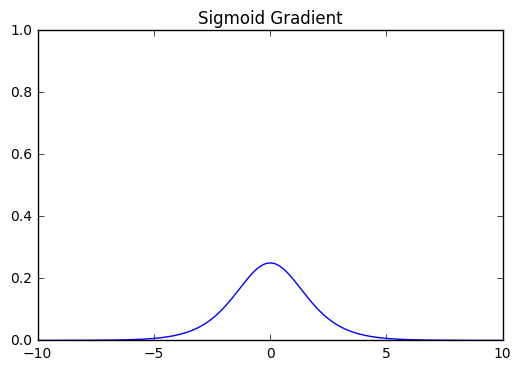

In [9]:
def sigmoid_gradient(t):
    return sigmoid(t) * (1-sigmoid(t))

plt.title("Sigmoid Gradient")
plt.ylim(0,1)
plt.plot(t, sigmoid_gradient(t))
plt.show()

# Normalize Data

Now that we understand the importantance of normalizing our dataset before we feed it into a LSTM neural network, let's look at how that's accomplished:

https://www.whitehouse.gov/sites/whitehouse.gov/files/documents/Artificial-Intelligence-Automation-Economy.PDF

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create Training and Test Sets

If we restructure the data, we can approach this challenge as a regression problem where we're trying to solve what next month's number of passengers is based on the current month's number. So we create two columns: the first is the current month's number of passengers and the second the following month's number of passengers.

In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)